In [ ]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import json
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2
import os
import statsmodels.api as sm

%matplotlib inline

##### What all do I need to load?
    - Raw brain
    - PCs, spatial and temporal
    - Model weights
    - Behavior video (fictrac-20190218_133014-raw.avi)
    - Anatomy

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

### Load raw brain

In [3]:
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 15.63 sec
brain shape is x,y,z,t (128, 84, 49, 4554)


### Load fictrac and timestamps

In [4]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 65.16 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.38 sec


### Load PCA

In [5]:
t0 = time()
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
print('Duration: {}'.format(time()-t0))

Duration: 24.262957334518433


In [6]:
pca_spatial.shape = (4554, -1)
pca_spatial.shape = (4554, 128, 84, 49)

### Load Models

In [7]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/20191106_analysis/20191106_models.json'
with open(file) as json_file:
    models = json.load(json_file)

### Load fictrac video

In [292]:
cap = cv2.VideoCapture('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/imports/fictrac/fictrac-20190218_133014-raw.avi')
i=0
frames = []
ret = True
while ret is True and i<80000:
    i+=1
    if i%1000 == 0:
        print(i)
    # Capture frame-by-frame
    ret, frame = cap.read()
    frames.append(frame)
cap.release()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000


### Load anatomy

In [9]:
brain_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/anat_0/anatomy.nii'
anatomy = bbb.load_numpy_brain(brain_path)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 546.33 ms


### Process fictrac

In [10]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [13]:
resolution = 20 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_high_res = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_high_res[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'xnew')

fictracs = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'timestamps')

##### Ok so whats the plan for interpolating everything correctly?
    - brain activity is at ~3Hz, 
    - fictrac video should be faster
    - behavior prediction should be plotted at ~3Hz I think

In [151]:
for behavior in ['Y', 'Z']:
    fictracs_std = np.std(fictracs[behavior])
    fictracs[behavior] = np.divide(fictracs[behavior],fictracs_std)

### Reconstruct temporal brain

In [14]:
pca_loadings_std = np.std(pca_loadings,axis=0)
pca_loadings = np.divide(pca_loadings,pca_loadings_std)

In [15]:
# Get correct model

for model in models:
    if model['fly'] == 'fly_19':
        if model['num_pcs'] == 500:
            model_ = model

In [17]:
# I think this is the right way to reconstruct the brain.

temporal_weights_Y = np.multiply(model_['coef_Y'], pca_loadings[:,:500])
reconstructed_brain_Y = np.tensordot(temporal_weights_Y, pca_spatial[:500,:,:,:],axes=1)

temporal_weights_Z = np.multiply(model_['coef_Z'], pca_loadings[:,:500])
reconstructed_brain_Z = np.tensordot(temporal_weights_Z, pca_spatial[:500,:,:,:],axes=1)

In [63]:
# first volume will be temporal_weights[0,:] * pca_spatial[:500,:,:,:]

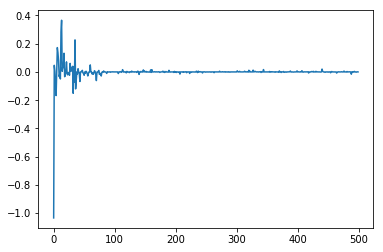

In [67]:
plt.plot(temporal_weights[0,:])

1190000
1190100
1190200
1190300
1190400
1190500
1190600
1190700
1190800
1190900
1191000
1191100
1191200
1191300
1191400
1191500
1191600
1191700
1191800
1191900
1192000
1192100
1192200
1192300
1192400
1192500
1192600
1192700
1192800
1192900
1193000
1193100
1193200
1193300
1193400
1193500
1193600
1193700
1193800
1193900
1194000
1194100
1194200
1194300
1194400
1194500
1194600
1194700
1194800
1194900
1195000
1195100
1195200
1195300
1195400
1195500
1195600
1195700
1195800
1195900
1196000
1196100
1196200
1196300
1196400
1196500
1196600
1196700
1196800
1196900
1197000
1197100
1197200
1197300
1197400
1197500
1197600
1197700
1197800
1197900
1198000
1198100
1198200
1198300
1198400
1198500
1198600
1198700
1198800
1198900
1199000
1199100
1199200
1199300
1199400
1199500
1199600
1199700
1199800
1199900
1200000
1200100
1200200
1200300
1200400
1200500
1200600
1200700
1200800
1200900
1201000
1201100
1201200
1201300
1201400
1201500
1201600
1201700
1201800
1201900
1202000
1202100
1202200
1202300
1202400


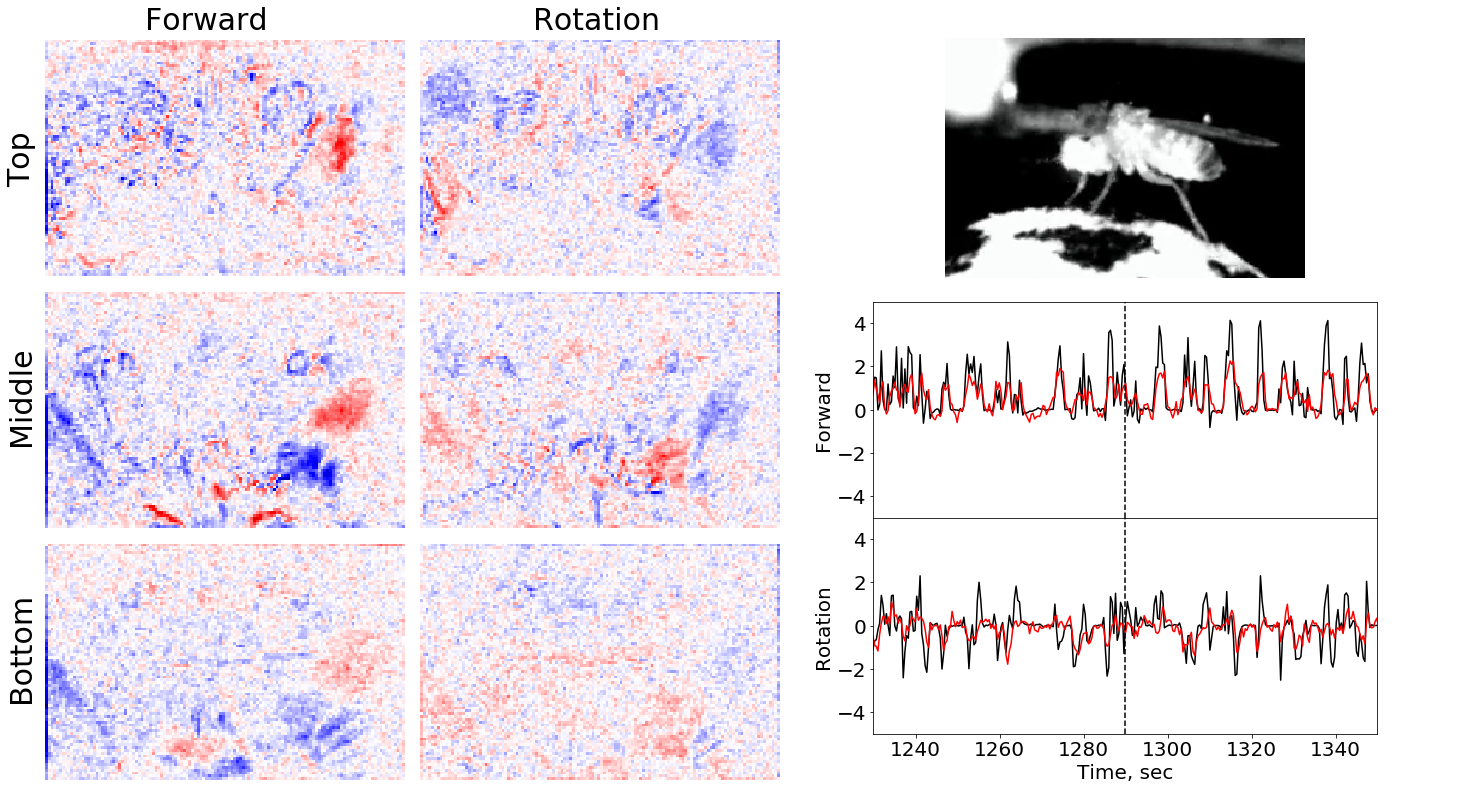

In [310]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191112_fly_and_brain_5'
#os.mkdir(save_path)

fig = plt.figure(figsize=(10,10))

start_ms = int(19.5*60*1000 + 20*1000)
stop_ms = int(start_ms + 100*1000) # seconds to ms
step_ms = 100

#start_ms = 0
#stop_ms = 100 # seconds to ms
#step_ms = 100
#z=0
for i in range(start_ms, stop_ms, step_ms):
    
    #z+=1
    #if z>1:
    #    break
    
    plt.clf()
    print(i)

    
    brain_idx = np.searchsorted(timestamps[:,20], i)
    behavior_idx = np.searchsorted(xnew, i)
    
    ##### Brain slices #####
    ax1 = fig.add_axes([0, 1, .5, .5])
    ax1.imshow(reconstructed_brain_Y[brain_idx,:,:,7].T,cmap='seismic',vmin=-.008,vmax=.008)
    ax1.axis('off')
    plt.text(35,-4,'Forward',fontsize=30)
    plt.text(-14,40,'Top',fontsize=30,rotation=90)
    
    ax2 = fig.add_axes([.52, 1, .5, .5])
    ax2.imshow(reconstructed_brain_Z[brain_idx,:,:,7].T,cmap='seismic',vmin=-.008,vmax=.008)
    ax2.axis('off')
    plt.text(40,-4,'Rotation',fontsize=30)
    
    ax3 = fig.add_axes([0, .65, .5, .5])
    ax3.imshow(reconstructed_brain_Y[brain_idx,:,:,15].T,cmap='seismic',vmin=-.008,vmax=.008)
    ax3.axis('off')
    plt.text(-14,27,'Middle',fontsize=30,rotation=90)
    
    ax4 = fig.add_axes([.52, .65, .5, .5])
    ax4.imshow(reconstructed_brain_Z[brain_idx,:,:,15].T,cmap='seismic',vmin=-.008,vmax=.008)
    ax4.axis('off')
    
    ax5 = fig.add_axes([0, .3, .5, .5])
    ax5.imshow(reconstructed_brain_Y[brain_idx,:,:,23].T,cmap='seismic',vmin=-.008,vmax=.008)
    ax5.axis('off')
    plt.text(-14,25,'Bottom',fontsize=30,rotation=90)
    
    ax6 = fig.add_axes([.52, .3, .5, .5])
    ax6.imshow(reconstructed_brain_Z[brain_idx,:,:,23].T,cmap='seismic',vmin=-.008,vmax=.008)
    ax6.axis('off')
    
    ##### Fly video #####
    ax7 = fig.add_axes([1.25, 1, .5, .5])
    ax7.imshow(frames[behavior_idx][25:225,250:550,:])
    ax7.axis('off')

    
    window = 60 
    
    ax8 = fig.add_axes([1.15, .75, .7, .3])
    ax8.plot(timestamps[:,20]/1000,fictracs['Y'],color='k')
    ax8.plot(timestamps[:,20]/1000,prediction[:,0],color='r')
    ax8.set_xlim(i/1000-window,i/1000+window)
    ax8.axvline(i/1000,linestyle='--',color='k')
    ax8.set_ylim(-2,5)
    ax8.xaxis.set_visible(False)
    ax8.tick_params(axis='y', labelsize=20)
    ax8.set_ylabel('Forward',fontsize=20)
    
    ax9 = fig.add_axes([1.15, .45, .7, .3],sharey=ax8)
    ax9.plot(timestamps[:,20]/1000,fictracs['Z'],color='k')
    ax9.plot(timestamps[:,20]/1000,prediction[:,1],color='r')
    ax9.set_xlim(i/1000-window,i/1000+window)
    ax9.axvline(i/1000,linestyle='--',color='k')
    ax9.set_ylim(-5,5)
    ax9.tick_params(axis='y', labelsize=20)
    ax9.tick_params(axis='x', labelsize=20)
    ax9.set_xlabel('Time, sec',fontsize=20)
    ax9.set_ylabel('Rotation',fontsize=20)
    
    ax10 = fig.add_axes([1.95, .45, .01, .01])
    ax10.axis('off')
    #circle = plt.Circle((0, 0), 10, color='r')
    #ax10.add_artist(circle)
    
    fname = os.path.join(save_path, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=100,bbox_inches='tight')

1170000
1170100
1170200
1170300
1170400
1170500
1170600
1170700
1170800
1170900
1171000
1171100
1171200
1171300
1171400
1171500
1171600
1171700
1171800
1171900
1172000
1172100
1172200
1172300
1172400
1172500
1172600
1172700
1172800
1172900
1173000
1173100
1173200
1173300
1173400
1173500
1173600
1173700
1173800
1173900
1174000
1174100
1174200
1174300
1174400
1174500
1174600
1174700
1174800
1174900
1175000
1175100
1175200
1175300
1175400
1175500
1175600
1175700
1175800
1175900
1176000
1176100
1176200
1176300
1176400
1176500
1176600
1176700
1176800
1176900
1177000
1177100
1177200
1177300
1177400
1177500
1177600
1177700
1177800
1177900
1178000
1178100
1178200
1178300
1178400
1178500
1178600
1178700
1178800
1178900
1179000
1179100
1179200
1179300
1179400
1179500
1179600
1179700
1179800
1179900
1180000
1180100
1180200
1180300
1180400
1180500
1180600
1180700
1180800
1180900
1181000
1181100
1181200
1181300
1181400
1181500
1181600
1181700
1181800
1181900
1182000
1182100
1182200
1182300
1182400


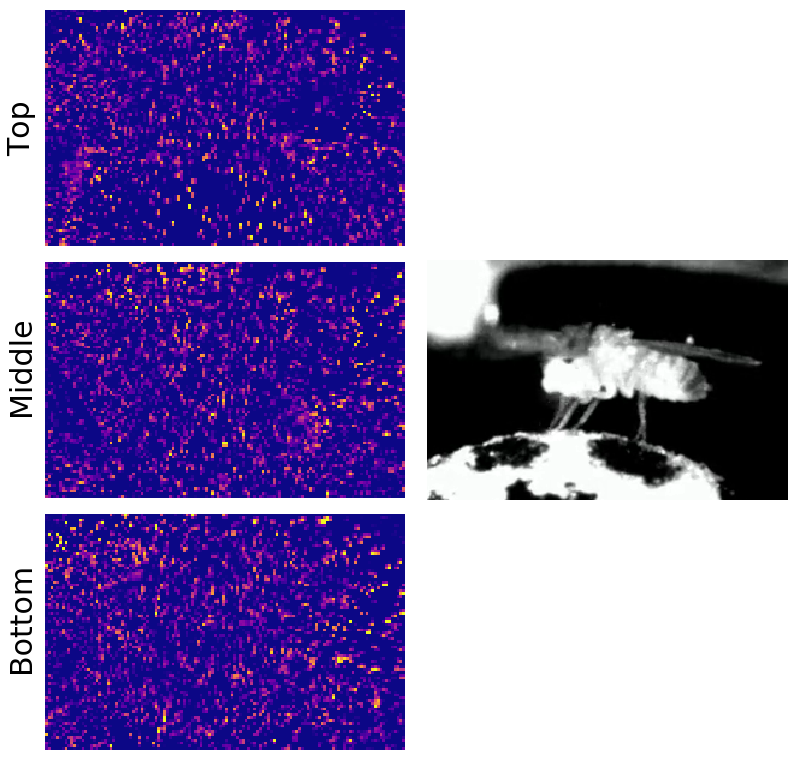

In [332]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191112_fly_and_brain_raw'
#os.mkdir(save_path)

fig = plt.figure(figsize=(10,10))

start_ms = int(19.5*60*1000)
stop_ms = int(start_ms + 100*1000) # seconds to ms
step_ms = 100

for i in range(start_ms, stop_ms, step_ms):
    
    plt.clf()
    print(i)
    
    brain_idx = np.searchsorted(timestamps[:,20], i)
    behavior_idx = np.searchsorted(xnew, i)
    
    ##### Brain slices #####
    ax1 = fig.add_axes([0, 1, .5, .5])
    ax1.imshow(brain[:,:,7,brain_idx].T,cmap='plasma',vmin=0,vmax=4)
    ax1.axis('off')
    plt.text(-14,40,'Top',fontsize=30,rotation=90)

    ax3 = fig.add_axes([0, .65, .5, .5])
    ax3.imshow(brain[:,:,15,brain_idx].T,cmap='plasma',vmin=0,vmax=4)
    ax3.axis('off')
    plt.text(-14,27,'Middle',fontsize=30,rotation=90)
    
    ax5 = fig.add_axes([0, .3, .5, .5])
    ax5.imshow(brain[:,:,23,brain_idx].T,cmap='plasma',vmin=0,vmax=4)
    ax5.axis('off')
    plt.text(-14,25,'Bottom',fontsize=30,rotation=90)

    
    ##### Fly video #####
    ax7 = fig.add_axes([.53, .65, .5, .5])
    ax7.imshow(frames[behavior_idx][25:225,250:550,:])
    ax7.axis('off')
    
    fname = os.path.join(save_path, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=100,bbox_inches='tight')

In [312]:
brain.shape

(128, 84, 49, 4554)

In [303]:
np.searchsorted(timestamps[:,20], i)

2919

In [301]:
timestamps[:,20]

array([2.30086740e+02, 6.31263620e+02, 1.03244050e+03, ...,
       1.82598607e+06, 1.82638724e+06, 1.82678842e+06])

In [302]:
xnew

array([      0,      20,      40, ..., 1799940, 1799960, 1799980])

(2900, 3400)

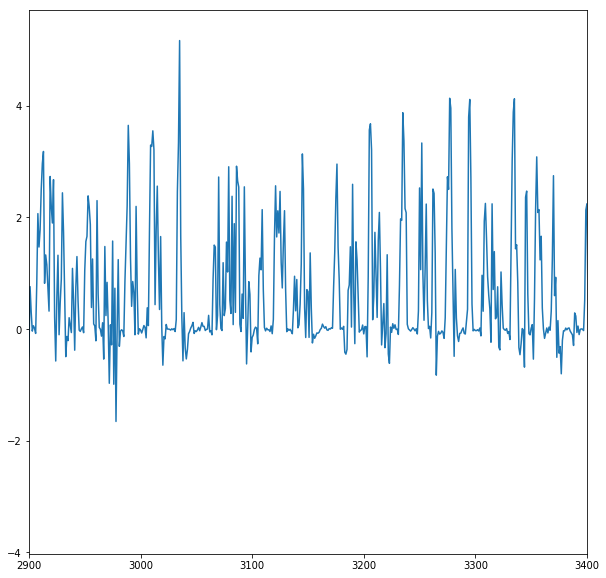

In [269]:
i=2900
plt.figure(figsize=(10,10))
plt.plot(fictracs['Y'])
plt.xlim(0+i,500+i)

In [265]:
fictracs['Y'].shape

(4554,)

In [268]:
np.searchsorted(timestamps[:,20], 1170000.0)

2916

In [266]:
19.5*60*1000

1170000.0

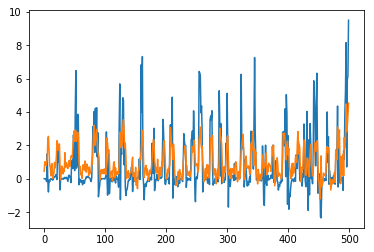

In [134]:
plt.plot(fictracs['Y'][:500])
plt.plot(prediction[:500,0])

In [188]:
xnew;
timestamps[,20]

(4554, 49)

In [193]:
timestamps[:,20]

array([2.30086740e+02, 6.31263620e+02, 1.03244050e+03, ...,
       1.82598607e+06, 1.82638724e+06, 1.82678842e+06])

In [189]:
xnew

array([      0,      50,     100, ..., 1799850, 1799900, 1799950])

In [197]:
start_ms = 0
stop_ms = 3*1000 # seconds to ms
step_ms = 100
for i in range(start_ms, stop_ms, step_ms):
    brain_idx = np.searchsorted(timestamps[:,20], i)
    behavior_idx = np.searchsorted(xnew, i)
    print('i: {}| brain_idx: {} | behavior_idx: {}'.format(i,brain_idx,behavior_idx))
    

i: 0| brain_idx: 0 | behavior_idx: 0
i: 100| brain_idx: 0 | behavior_idx: 2
i: 200| brain_idx: 0 | behavior_idx: 4
i: 300| brain_idx: 1 | behavior_idx: 6
i: 400| brain_idx: 1 | behavior_idx: 8
i: 500| brain_idx: 1 | behavior_idx: 10
i: 600| brain_idx: 1 | behavior_idx: 12
i: 700| brain_idx: 2 | behavior_idx: 14
i: 800| brain_idx: 2 | behavior_idx: 16
i: 900| brain_idx: 2 | behavior_idx: 18
i: 1000| brain_idx: 2 | behavior_idx: 20
i: 1100| brain_idx: 3 | behavior_idx: 22
i: 1200| brain_idx: 3 | behavior_idx: 24
i: 1300| brain_idx: 3 | behavior_idx: 26
i: 1400| brain_idx: 3 | behavior_idx: 28
i: 1500| brain_idx: 4 | behavior_idx: 30
i: 1600| brain_idx: 4 | behavior_idx: 32
i: 1700| brain_idx: 4 | behavior_idx: 34
i: 1800| brain_idx: 4 | behavior_idx: 36
i: 1900| brain_idx: 5 | behavior_idx: 38
i: 2000| brain_idx: 5 | behavior_idx: 40
i: 2100| brain_idx: 5 | behavior_idx: 42
i: 2200| brain_idx: 5 | behavior_idx: 44
i: 2300| brain_idx: 6 | behavior_idx: 46
i: 2400| brain_idx: 6 | behavior_

In [127]:
from sklearn.linear_model import MultiTaskLassoCV

In [152]:
Y_glm = np.vstack((fictracs['Y'], fictracs['Z'])).T
X_glm = pca_loadings[:,:500]
model_for_prediction = MultiTaskLassoCV()
model_for_prediction.fit(X_glm,Y_glm)

MultiTaskLassoCV(alphas=None, copy_X=True, cv=None, eps=0.001,
         fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
         normalize=False, random_state=None, selection='cyclic',
         tol=0.0001, verbose=False)

In [153]:
prediction = model_for_prediction.predict(X_glm)

In [144]:
# What should reconstructed activity at t=100 look like?
# It should be:
# the value of PC 1-500, each weighted by model coefs
out = np.multiply(model_['coef_Y'], pca_loadings[100,:500])
# Then, each multiplied by its spatial distribution
out2 = np.tensordot(out, pca_spatial[:500,:,:,:],axes=1)
# Finally summed

